In [6]:
import os
import glob
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [7]:
def find_file(folder, base_name):
    """
    Look for base_name.csv or base_name.csv.gz inside folder.
    """
    pattern = os.path.join(folder, f"{base_name}.csv*")
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(
            f"Could not find {base_name}.csv or {base_name}.csv.gz in {folder}"
        )
    return matches[0]

def load_city_snapshot(city_name, snapshot_label, base_dir="../data", max_nights=200_000):
    """
    Memory-friendly loader:
    - Reads only needed columns
    - Optionally samples up to `max_nights` rows from calendar
    """
    folder = os.path.join(base_dir, snapshot_label)

    calendar_path = find_file(folder, "calendar")
    listings_path = find_file(folder, "listings")

    # ---- Read only needed calendar columns ----
    cal_head = pd.read_csv(calendar_path, nrows=0)
    cal_keep = ["listing_id", "date", "available", "price"]
    cal_cols = [c for c in cal_keep if c in cal_head.columns]

    calendar = pd.read_csv(calendar_path, usecols=cal_cols)

    # Optional: sample to avoid memory blow-up
    if (max_nights is not None) and (len(calendar) > max_nights):
        calendar = calendar.sample(n=max_nights, random_state=42)

    # ---- Read only needed listings columns ----
    list_head = pd.read_csv(listings_path, nrows=0)
    listing_keep = [
        "id",
        "room_type",
        "accommodates",
        "bedrooms",
        "beds",
        "minimum_nights",
        "maximum_nights",
        "number_of_reviews",
        "review_scores_rating",
    ]
    list_cols = [c for c in listing_keep if c in list_head.columns]

    listings = pd.read_csv(listings_path, usecols=list_cols)

    # ---- Merge calendar.listing_id with listings.id ----
    merged = calendar.merge(
        listings,
        left_on="listing_id",
        right_on="id",
        how="left",
        suffixes=("_cal", "_list"),
    )

    # ---- Clean / engineer features ----
    if "price" in merged.columns:
        merged["price"] = (
            merged["price"]
            .astype(str)
            .str.replace(r"[$,]", "", regex=True)
            .astype("float32")
        )

    merged["is_booked"] = (merged["available"] == "f").astype("int8")
    merged["date"] = pd.to_datetime(merged["date"])

    merged["month"] = merged["date"].dt.month.astype("int8")
    merged["day_of_week"] = merged["date"].dt.dayofweek.astype("int8")
    merged["week_of_year"] = merged["date"].dt.isocalendar().week.astype("int16")
    merged["day_of_year"] = merged["date"].dt.dayofyear.astype("int16")
    merged["is_weekend"] = merged["day_of_week"].isin([5, 6]).astype("int8")

    merged["city"] = city_name
    merged["snapshot"] = snapshot_label

    return merged


In [8]:
austin_2025 = load_city_snapshot("Austin", "austin_2025-03-06")
austin_2025.head()

,listing_id,date,available,price,id,room_type,accommodates,bedrooms,beds,minimum_nights,...,number_of_reviews,review_scores_rating,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend,city,snapshot
0,817221271773290014,2025-12-04,t,244.0,817221271773290014,Entire home/apt,6,2.0,3.0,1,...,98,4.90,0,12,3,49,338,0,Austin,austin_2025-03-06
1,563284927382646563,2025-05-26,t,55.0,563284927382646563,Private room,2,1.0,0.0,3,...,2,5.00,0,5,0,22,146,0,Austin,austin_2025-03-06
2,7996932,2026-03-07,f,75.0,7996932,Private room,2,NaN,NaN,1,...,15,5.00,1,3,5,10,66,1,Austin,austin_2025-03-06
3,10501614,2025-03-13,f,75.0,10501614,Private room,2,NaN,NaN,2,...,3,5.00,1,3,3,11,72,0,Austin,austin_2025-03-06
4,1183715103525009858,2025-08-13,t,122.0,1183715103525009858,Entire home/apt,3,1.0,2.0,1,...,11,4.36,0,8,2,33,225,0,Austin,austin_2025-03-06


## Part 1 – Building a Night-Level Panel Dataset

In this section I construct a unified **night-level panel dataset** using
InsideAirbnb data for four cities and two snapshots per city:

- Austin – 2024-12-14, 2025-03-06  
- Chicago – 2024-12-18, 2025-03-11  
- Santa Cruz – 2025-03-28, 2025-12-31  
- Washington DC – 2025-03-13, 2025-12-18  

For each city–date combination I load the corresponding `calendar` and
`listings` files and **left-join** them on `listing_id = id`.  
This produces one row per **listing-night** with both calendar information
(availability, nightly price, date) and key listing attributes (room type,
capacity, review scores, etc.). To keep the dataset memory-efficient, I
only read the columns that are needed later in the analysis and models.

After the merge, I perform several cleaning and feature-engineering steps:

1. **Price cleaning** – convert the `price` column from strings
   (e.g. `"$125.00"`) to numeric dollars by removing currency symbols and
   commas and casting to a floating-point type.
2. **Booking indicator** – create an `is_booked` flag, where
   `is_booked = 1` if `available == 'f'` (the night is booked) and
   `is_booked = 0` if `available == 't'`.
3. **Time-based features** – parse the `date` column and derive:
   - `month` (1–12)  
   - `day_of_week` (0 = Monday, …, 6 = Sunday)  
   - `week_of_year` (ISO week number)  
   - `day_of_year` (1–366)  
   - `is_weekend` (1 for Saturday/Sunday, 0 otherwise)
4. **City and snapshot labels** – add `city` and `snapshot` columns so that
   each row knows which **metro area** and **data extract date** it belongs to.

**Practical note:** The raw InsideAirbnb calendar files contain millions
of listing-nights across all cities and snapshots, which exceeded the
available memory on my local machine. To make the analysis feasible, I
randomly sample up to 200,000 nights per city–snapshot when constructing
the panel. This preserves the temporal and cross-sectional structure of
the data (all four cities and both snapshots per city) while keeping the
dataset small enough to process and model.

Finally, I concatenate all city–snapshot DataFrames into a single
`panel` DataFrame. This panel is the main dataset used in the rest of the
assignment for seasonality analysis and for training machine-learning
models to predict nightly **price** and **booking probability**.


In [9]:
snapshots = [
    ("Austin", "austin_2025-03-06"),
    ("Austin", "austin_2024-12-14"),
    ("Chicago", "chicago_2025-03-11"),
    ("Chicago", "chicago_2024-12-18"),
    ("Santa Cruz", "santacruz_2025-03-28"),
    ("Santa Cruz", "santacruz_2025-12-31"),
    ("Washington DC", "dc_2025-03-13"),
    ("Washington DC", "dc_2025-12-18"),
]

panel_list = []

for city, label in snapshots:
    df = load_city_snapshot(city, label, base_dir="../data", max_nights=200_000)
    print(city, label, "rows after sampling:", len(df))
    panel_list.append(df)

panel = pd.concat(panel_list, ignore_index=True)

print("Full panel shape:", panel.shape)
print(panel[["city", "snapshot"]].value_counts().sort_index())
panel.head()


Austin austin_2025-03-06 rows after sampling: 200000
Austin austin_2024-12-14 rows after sampling: 200000
Chicago chicago_2025-03-11 rows after sampling: 200000
Chicago chicago_2024-12-18 rows after sampling: 200000
Santa Cruz santacruz_2025-03-28 rows after sampling: 200000
Santa Cruz santacruz_2025-12-31 rows after sampling: 200000
Washington DC dc_2025-03-13 rows after sampling: 200000
Washington DC dc_2025-12-18 rows after sampling: 200000
Full panel shape: (1600000, 21)
city           snapshot            
Austin         austin_2024-12-14       200000
               austin_2025-03-06       200000
Chicago        chicago_2024-12-18      200000
               chicago_2025-03-11      200000
Santa Cruz     santacruz_2025-03-28    200000
               santacruz_2025-12-31    200000
Washington DC  dc_2025-03-13           200000
               dc_2025-12-18           200000
Name: count, dtype: int64


,listing_id,date,available,price,id,room_type,accommodates,bedrooms,beds,minimum_nights,...,number_of_reviews,review_scores_rating,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend,city,snapshot
0,817221271773290014,2025-12-04,t,244.0,817221271773290014,Entire home/apt,6,2.0,3.0,1,...,98,4.90,0,12,3,49,338,0,Austin,austin_2025-03-06
1,563284927382646563,2025-05-26,t,55.0,563284927382646563,Private room,2,1.0,0.0,3,...,2,5.00,0,5,0,22,146,0,Austin,austin_2025-03-06
2,7996932,2026-03-07,f,75.0,7996932,Private room,2,NaN,NaN,1,...,15,5.00,1,3,5,10,66,1,Austin,austin_2025-03-06
3,10501614,2025-03-13,f,75.0,10501614,Private room,2,NaN,NaN,2,...,3,5.00,1,3,3,11,72,0,Austin,austin_2025-03-06
4,1183715103525009858,2025-08-13,t,122.0,1183715103525009858,Entire home/apt,3,1.0,2.0,1,...,11,4.36,0,8,2,33,225,0,Austin,austin_2025-03-06


## Part 2 – Seasonality Analysis

In this section I examine how Airbnb prices and booking probabilities vary
over time for each city and snapshot. For each (city, snapshot) pair I
compute and visualize:

1. Average nightly price by month (line plot),
2. Average booking probability by month (line plot),
3. Weekend vs weekday averages for both price and booking probability
   (bar charts),
4. Average price by month, grouped by room type (line plot).

These plots reveal seasonal patterns and differences across cities and
listing types.


In [10]:
def plot_monthly_price(df, title_suffix=""):
    """Line plot: average nightly price by month."""
    sub = df.copy()
    sub = sub[sub["price"].notna()]
    monthly = sub.groupby("month", as_index=False)["price"].mean()

    plt.figure()
    plt.plot(monthly["month"], monthly["price"], marker="o")
    plt.xlabel("Month")
    plt.ylabel("Average nightly price (USD)")
    plt.title(f"Average price by month – {title_suffix}")
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()


def plot_monthly_booking_prob(df, title_suffix=""):
    """Line plot: booking probability by month."""
    monthly = df.groupby("month", as_index=False)["is_booked"].mean()

    plt.figure()
    plt.plot(monthly["month"], monthly["is_booked"], marker="o")
    plt.xlabel("Month")
    plt.ylabel("Booking probability (P(is_booked = 1))")
    plt.title(f"Booking probability by month – {title_suffix}")
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()


def plot_weekend_weekday(df, title_suffix=""):
    """
    Bar charts: weekend vs weekday for price and booking probability.
    """
    agg = df.groupby("is_weekend").agg(
        avg_price=("price", "mean"),
        book_prob=("is_booked", "mean")
    ).reset_index()

    agg["day_type"] = np.where(agg["is_weekend"] == 1, "Weekend", "Weekday")
    print("Weekend vs weekday summary:")
    display(agg[["day_type", "avg_price", "book_prob"]])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(agg["day_type"], agg["avg_price"])
    axes[0].set_title(f"Average price – weekend vs weekday\n{title_suffix}")
    axes[0].set_ylabel("Average nightly price (USD)")

    axes[1].bar(agg["day_type"], agg["book_prob"])
    axes[1].set_title(f"Booking probability – weekend vs weekday\n{title_suffix}")
    axes[1].set_ylabel("P(is_booked = 1)")

    plt.tight_layout()
    plt.show()


def plot_price_by_month_and_type(df, cat_col="room_type", title_suffix=""):
    """
    Line plot: average price by month, grouped by a categorical listing variable.
    Here we use room_type and limit to the top few categories.
    """
    sub = df.copy()
    sub = sub[sub["price"].notna()]

    top_cats = sub[cat_col].value_counts().head(4).index
    sub = sub[sub[cat_col].isin(top_cats)]

    grp = sub.groupby(["month", cat_col], as_index=False)["price"].mean()

    plt.figure()
    for cat in top_cats:
        d = grp[grp[cat_col] == cat]
        plt.plot(d["month"], d["price"], marker="o", label=cat)

    plt.xlabel("Month")
    plt.ylabel("Average nightly price (USD)")
    plt.title(f"Average price by month and {cat_col} – {title_suffix}")
    plt.xticks(range(1, 13))
    plt.legend(title=cat_col)
    plt.tight_layout()
    plt.show()



Austin – austin_2025-03-06
Rows in sample: 200000


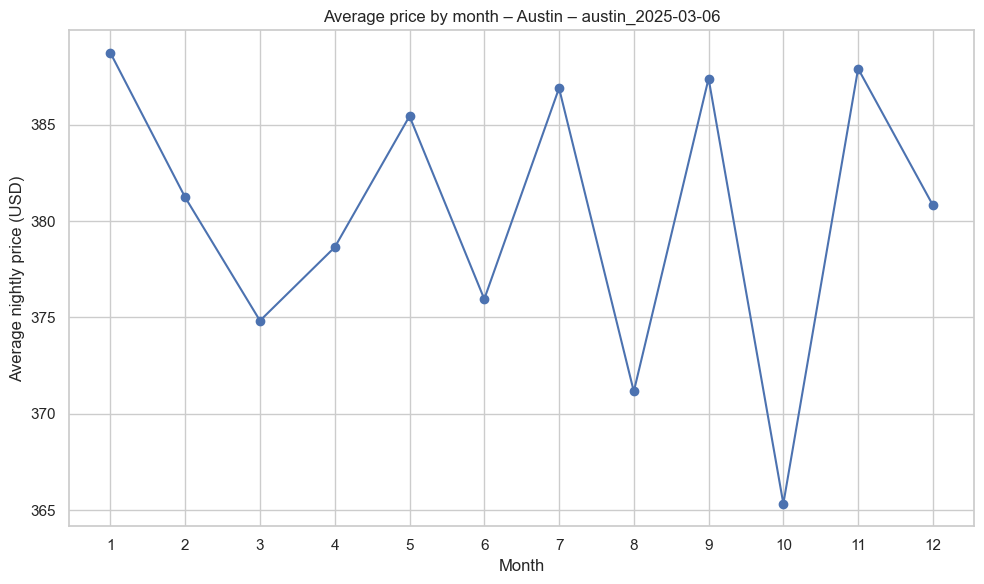

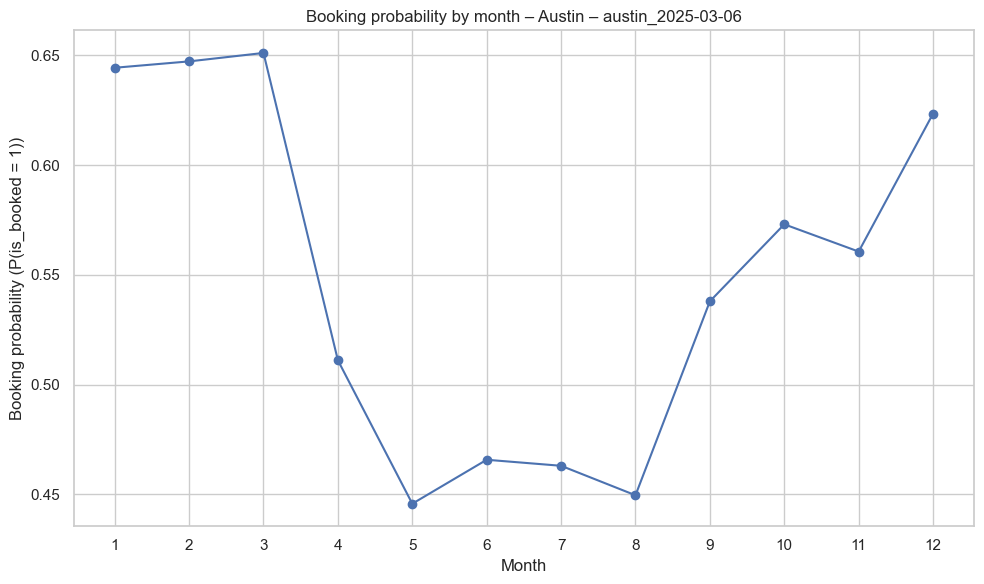

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,380.443848,0.546072
1,Weekend,380.039459,0.550428


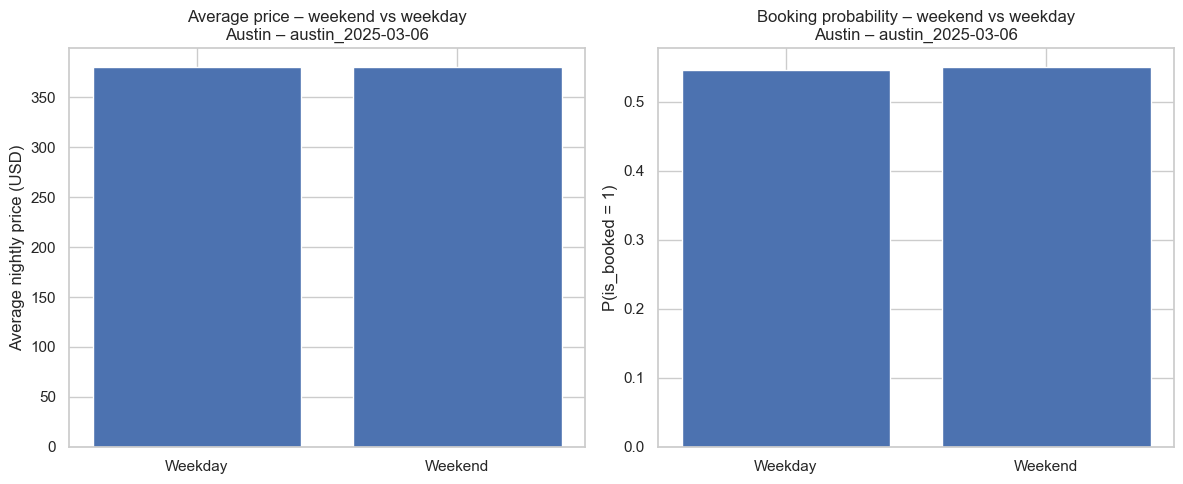

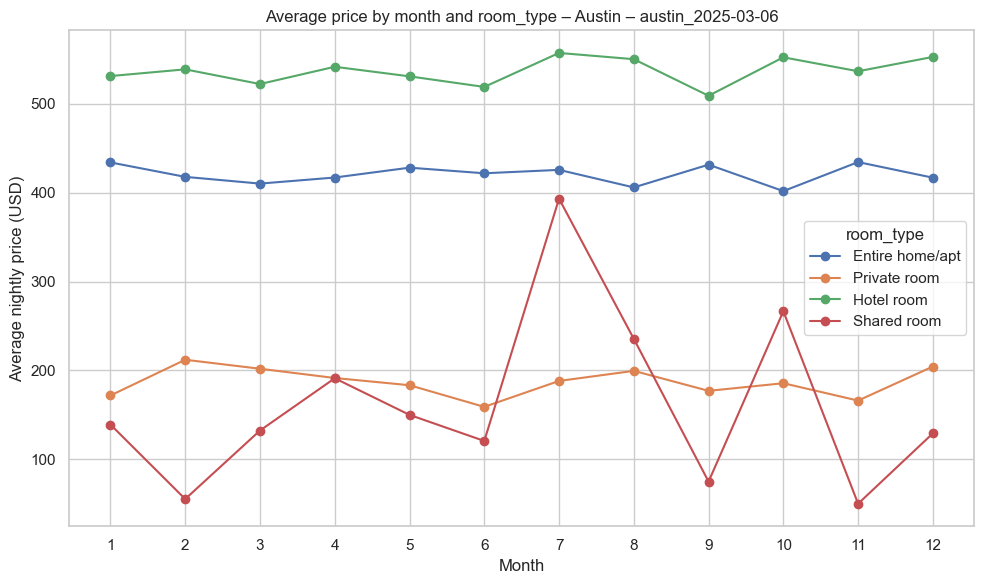


Austin – austin_2024-12-14
Rows in sample: 200000


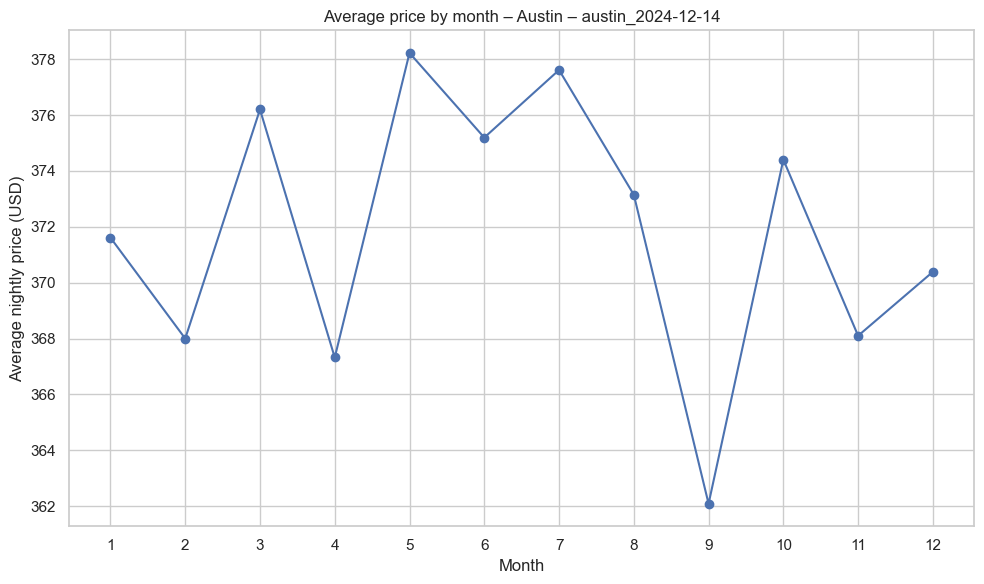

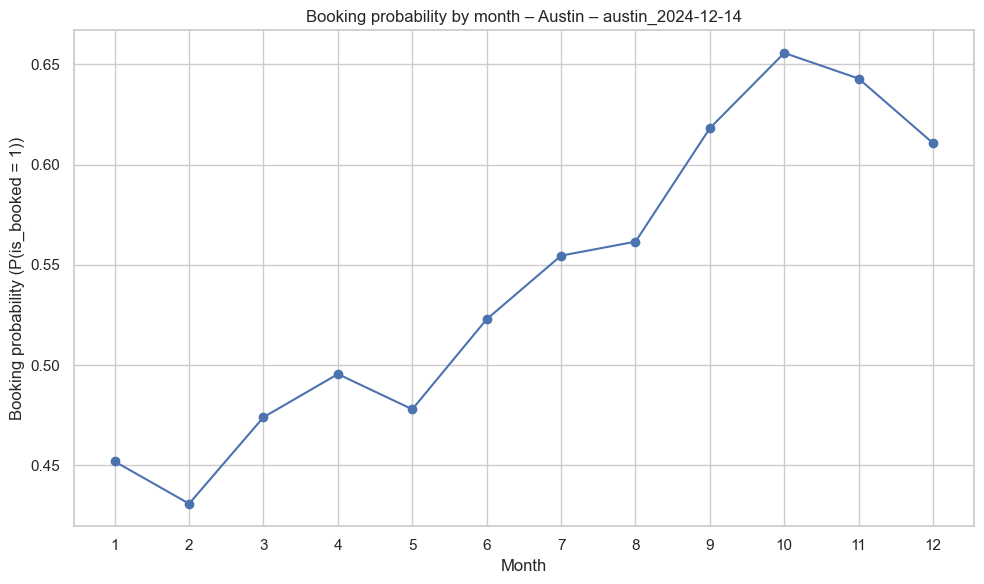

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,371.951813,0.540324
1,Weekend,371.941711,0.547136


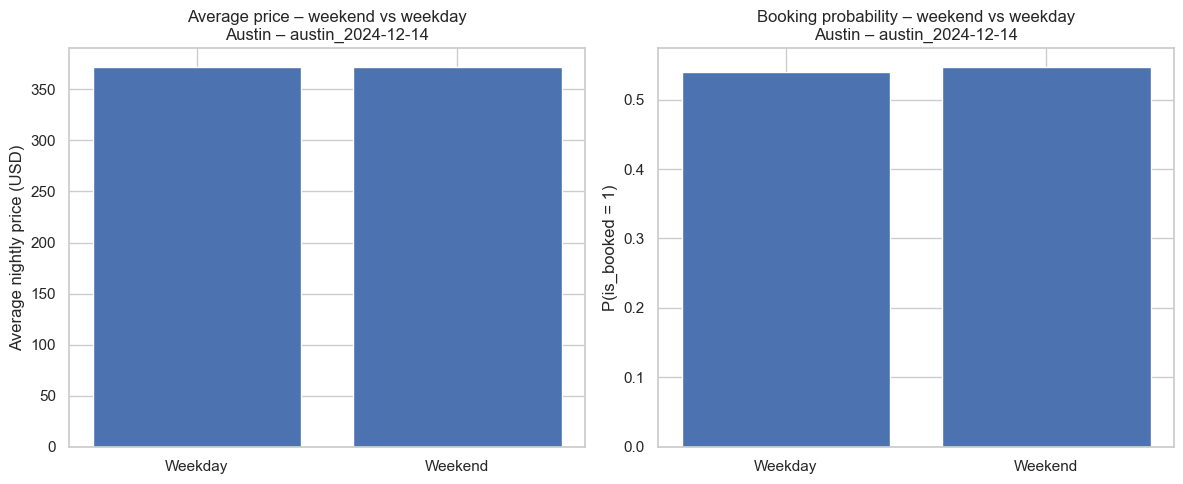

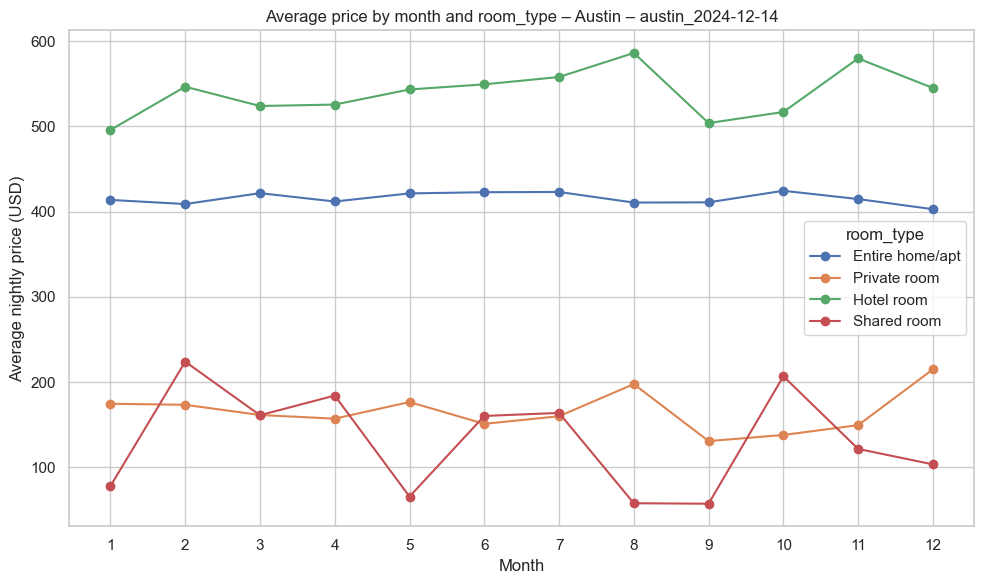


Chicago – chicago_2025-03-11
Rows in sample: 200000


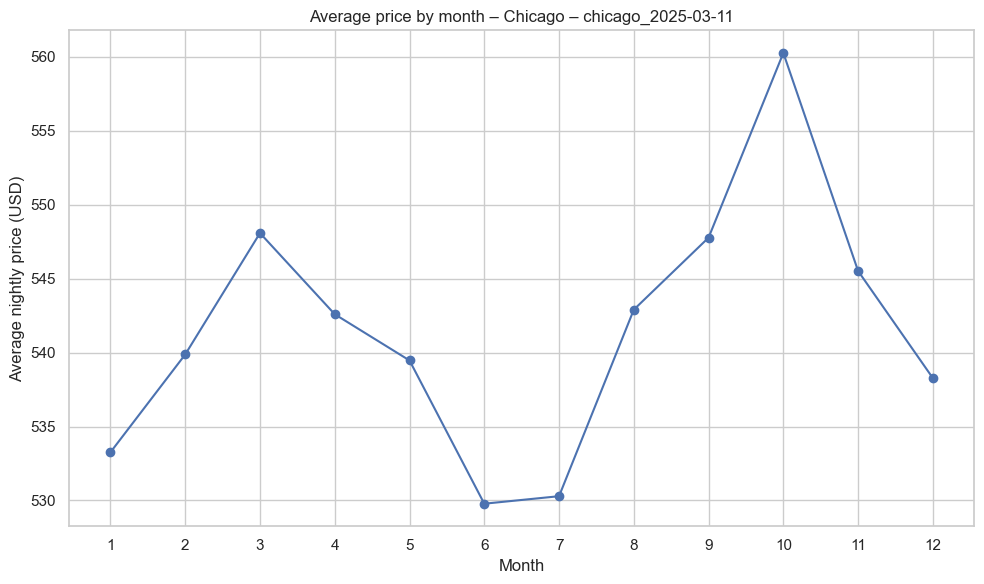

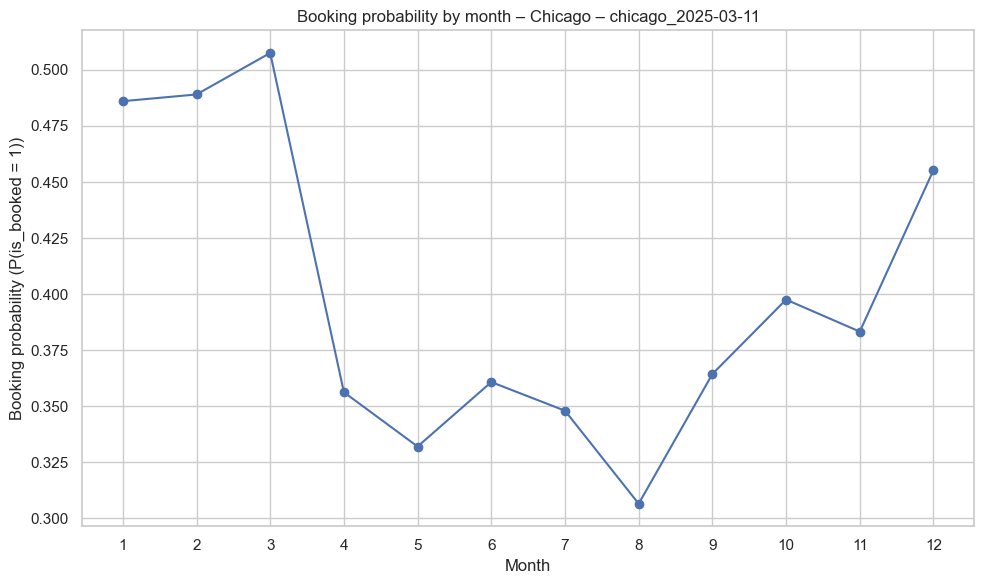

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,541.006592,0.394563
1,Weekend,542.872925,0.409157


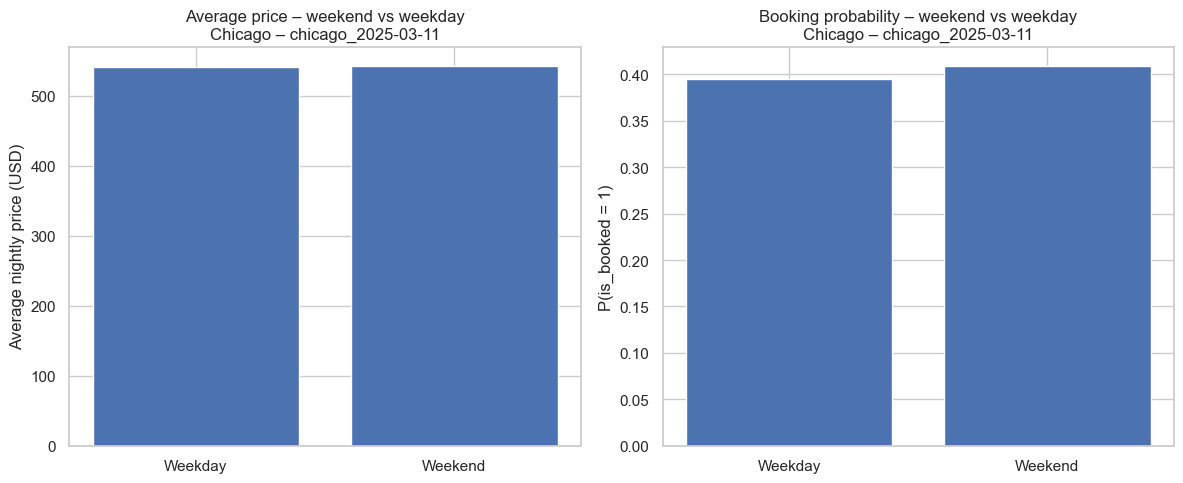

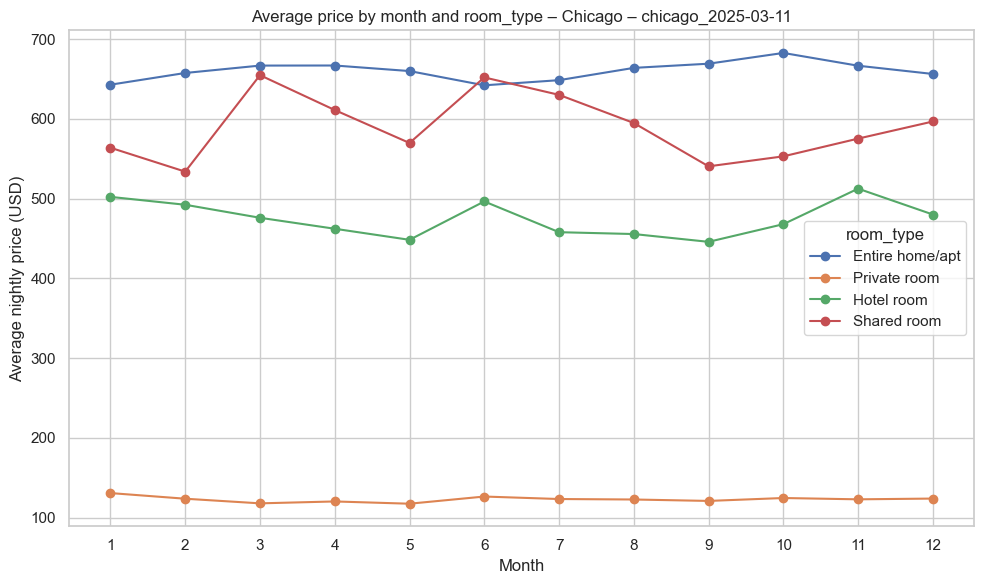


Chicago – chicago_2024-12-18
Rows in sample: 200000


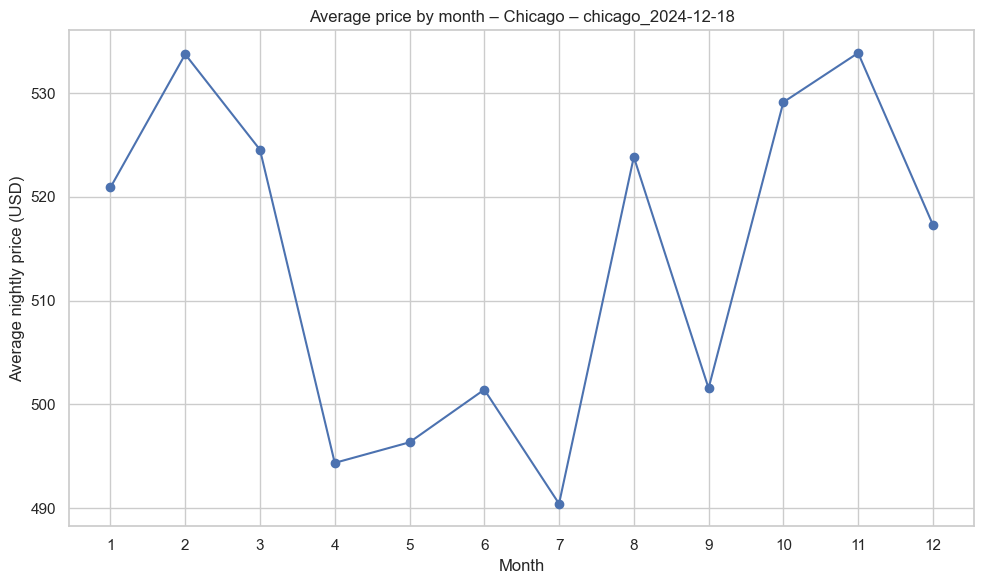

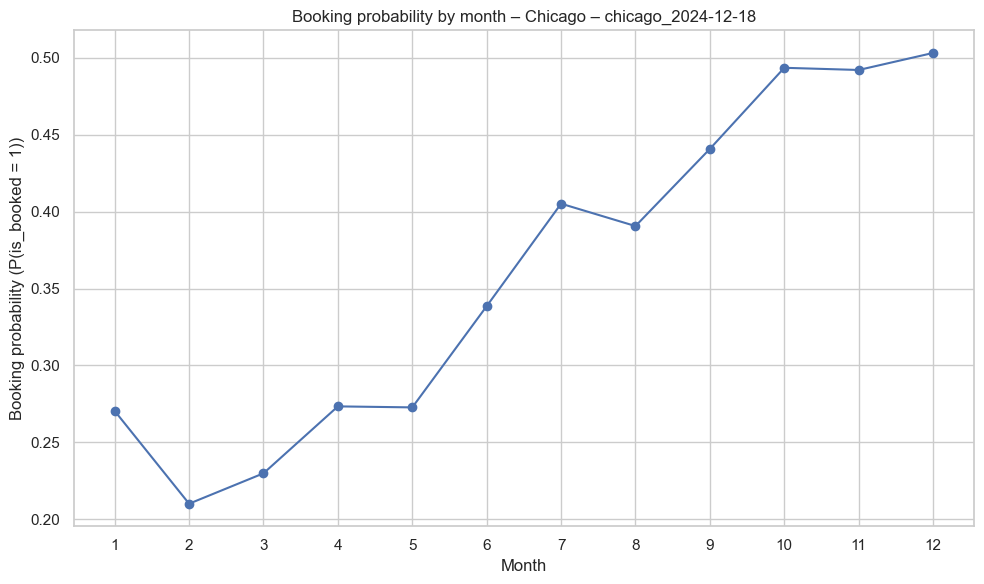

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,510.718140,0.360303
1,Weekend,521.758911,0.362175


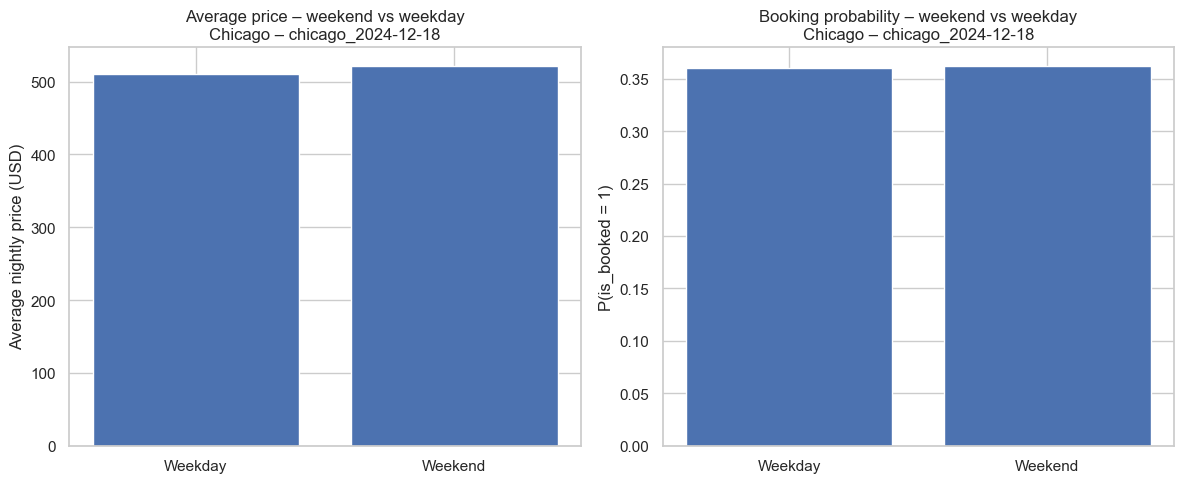

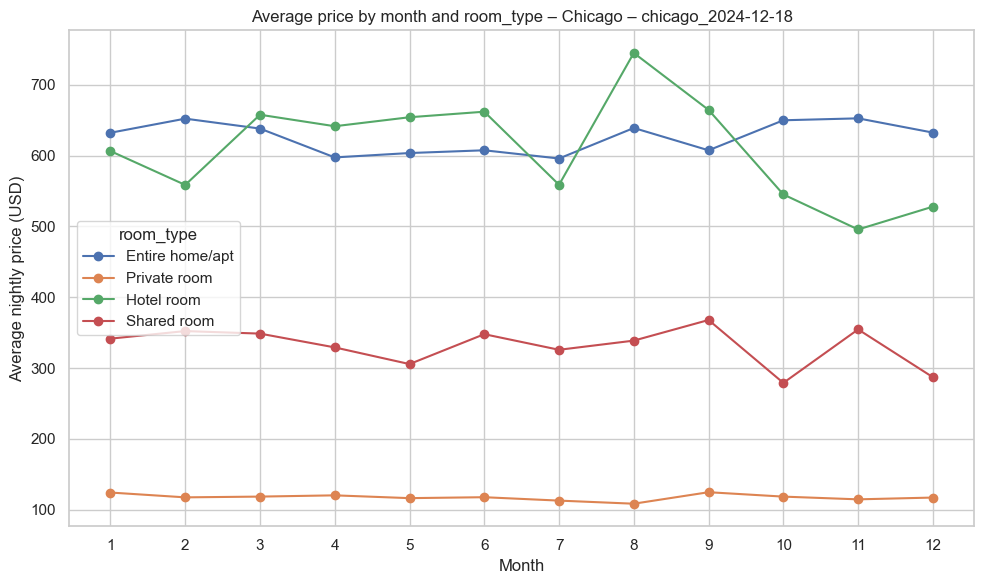


Santa Cruz – santacruz_2025-03-28
Rows in sample: 200000


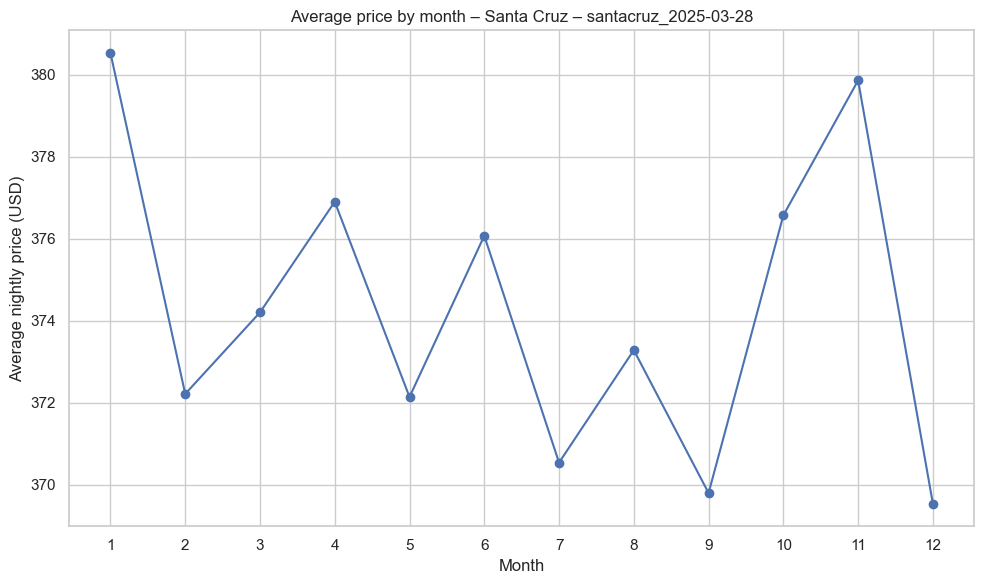

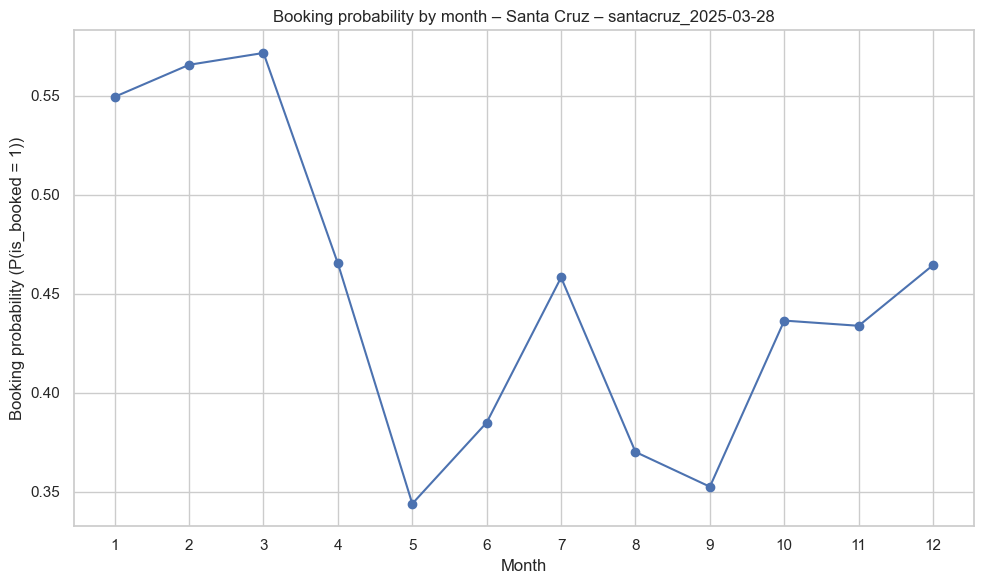

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,373.826996,0.445353
1,Weekend,375.510010,0.458412


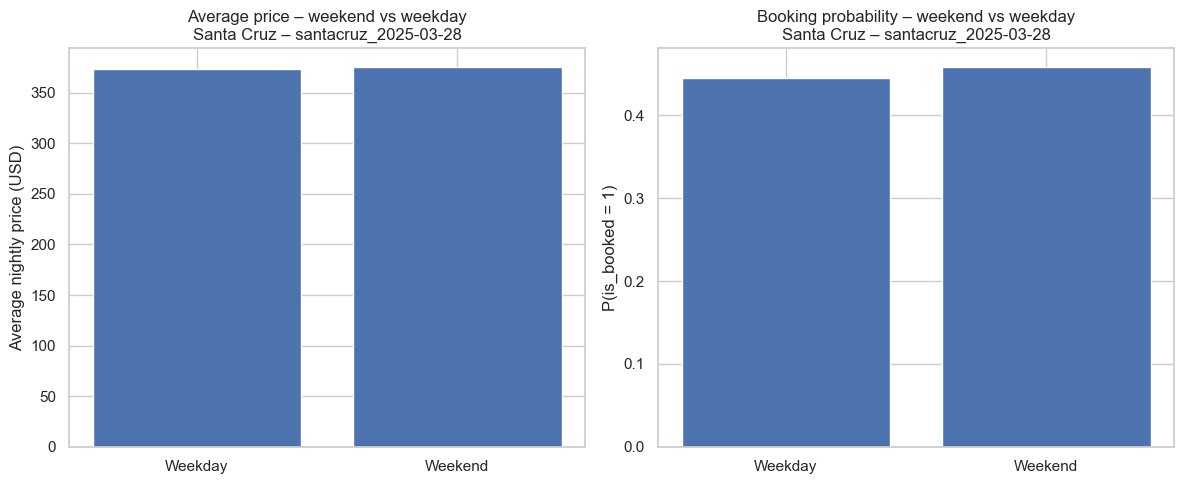

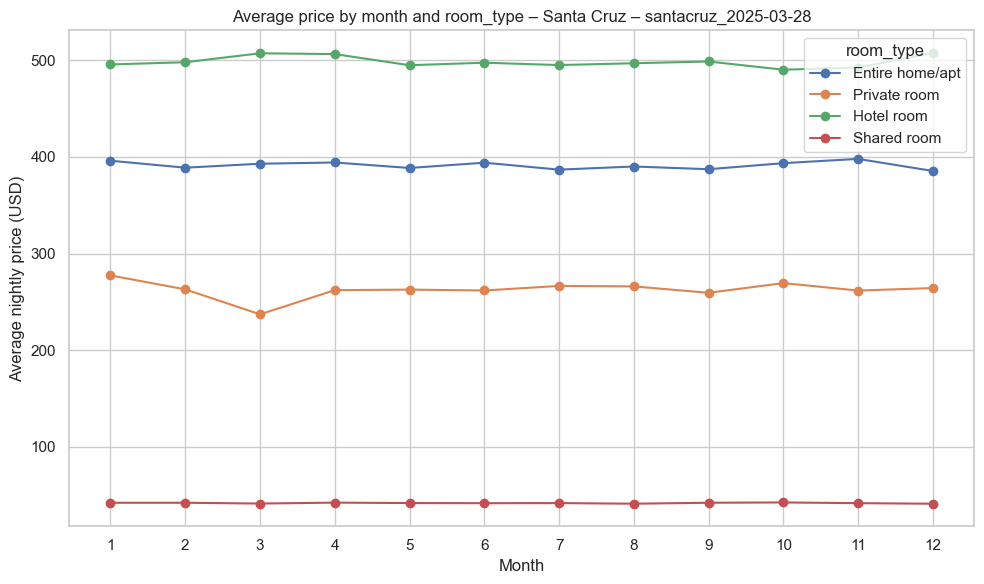


Santa Cruz – santacruz_2025-12-31
Rows in sample: 200000


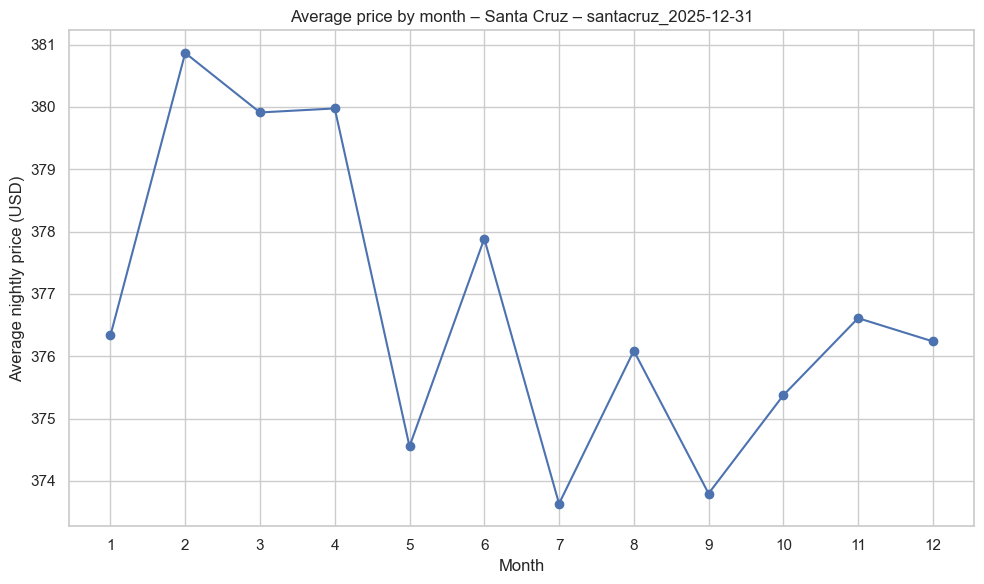

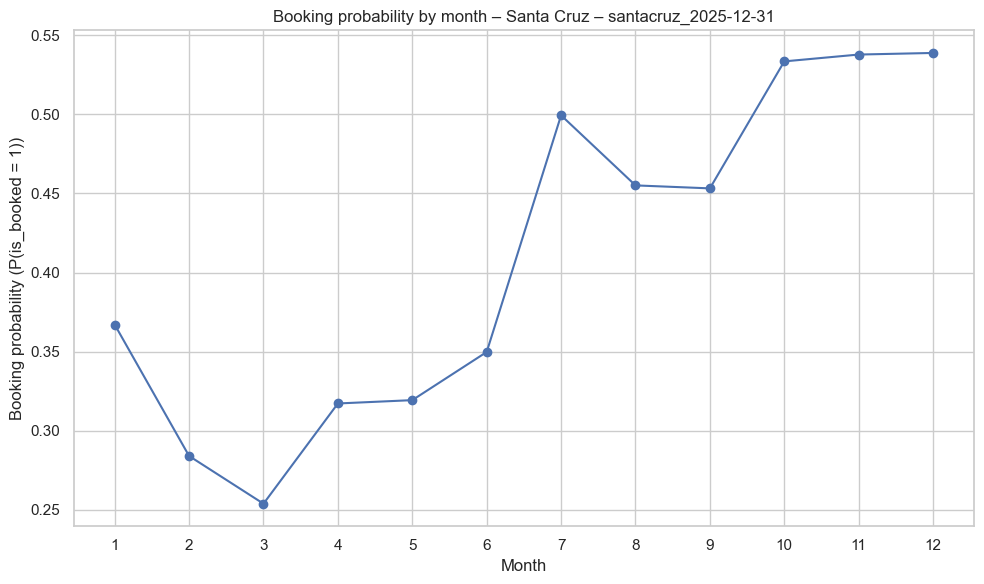

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,377.314941,0.408380
1,Weekend,375.301086,0.412176


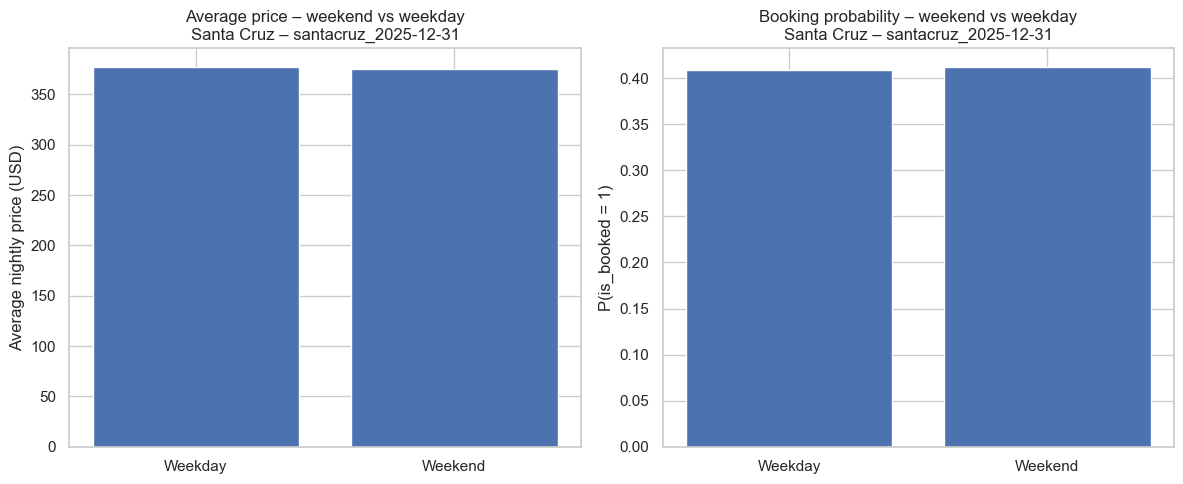

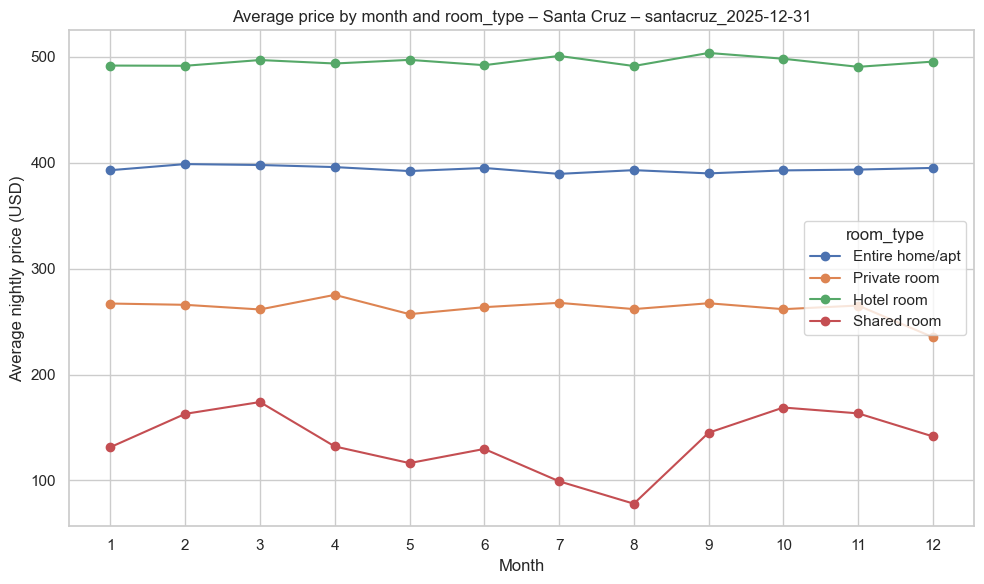


Washington DC – dc_2025-03-13
Rows in sample: 200000


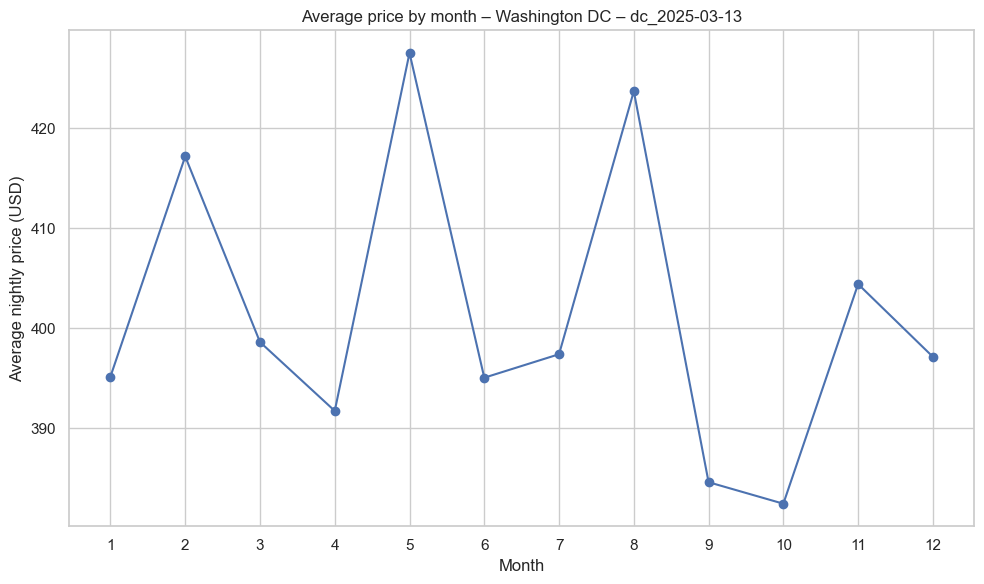

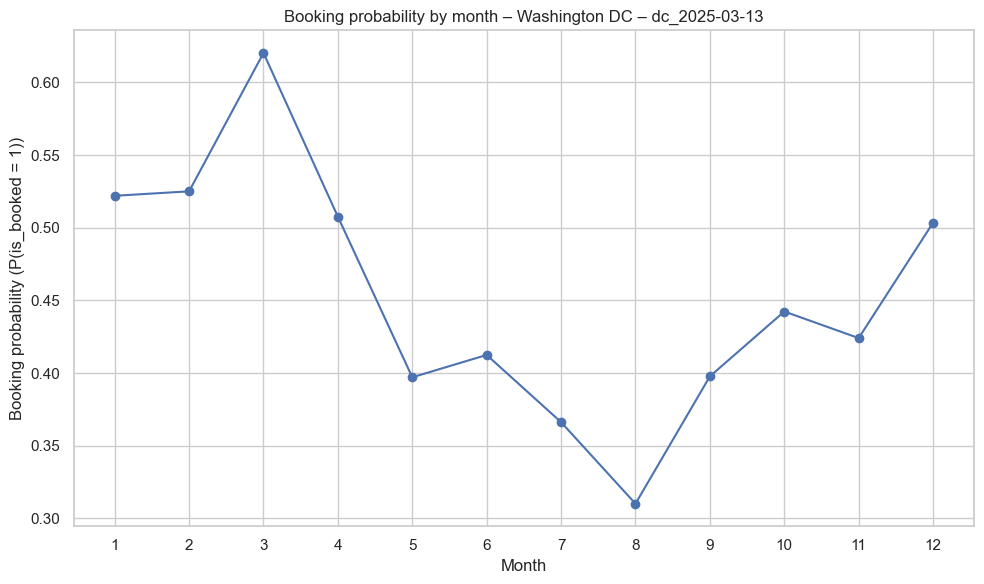

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,401.236328,0.449349
1,Weekend,401.206085,0.458336


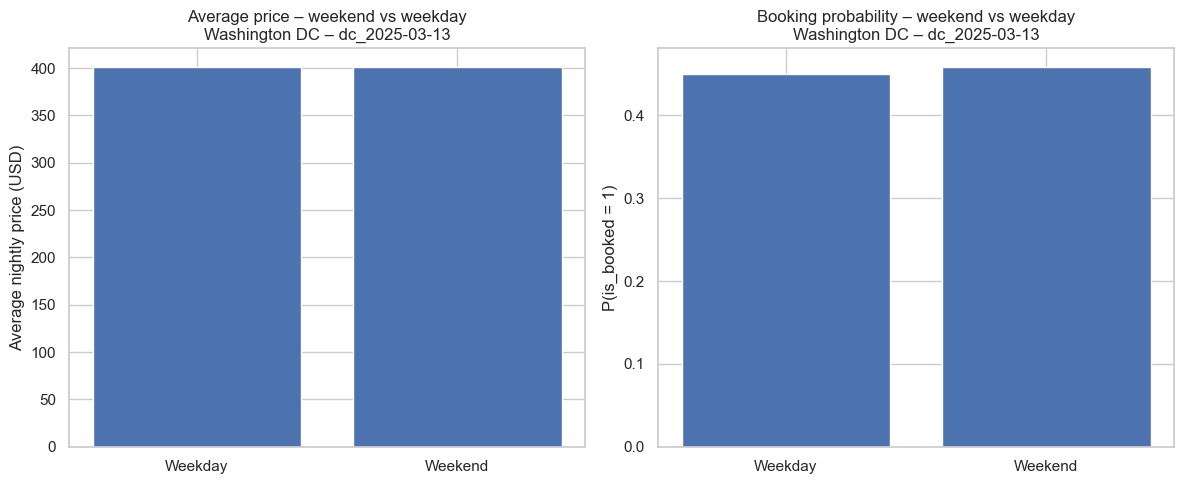

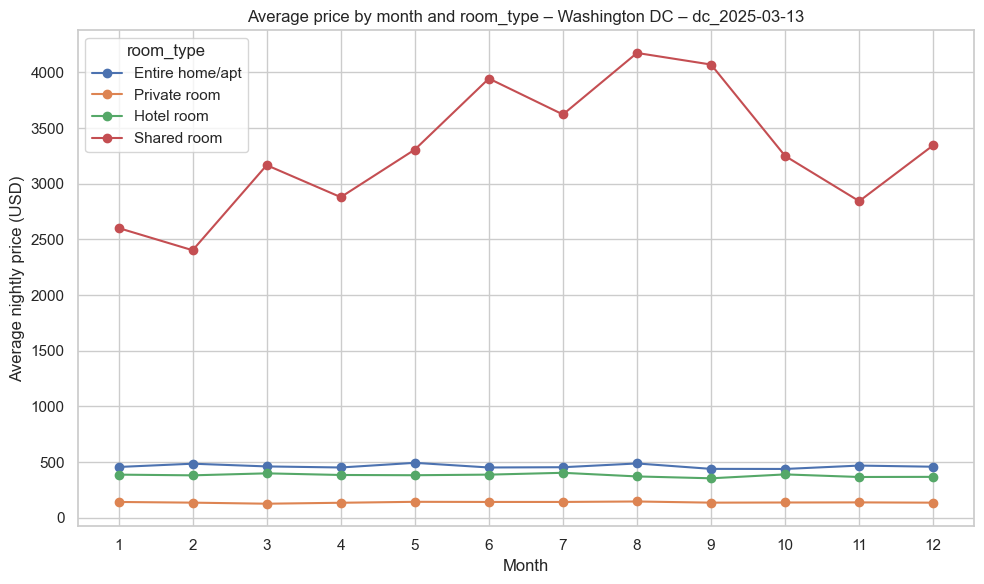


Washington DC – dc_2025-12-18
Rows in sample: 200000


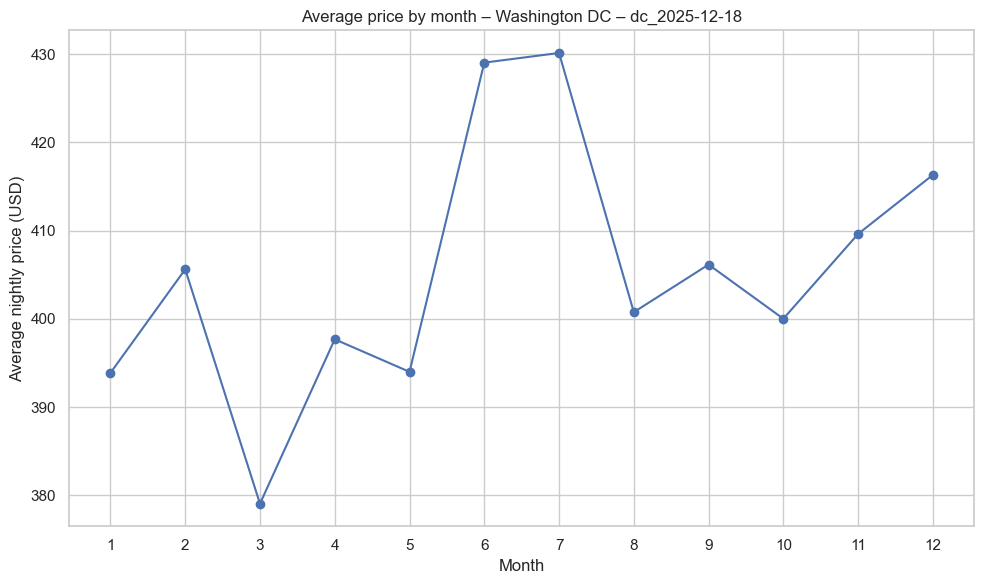

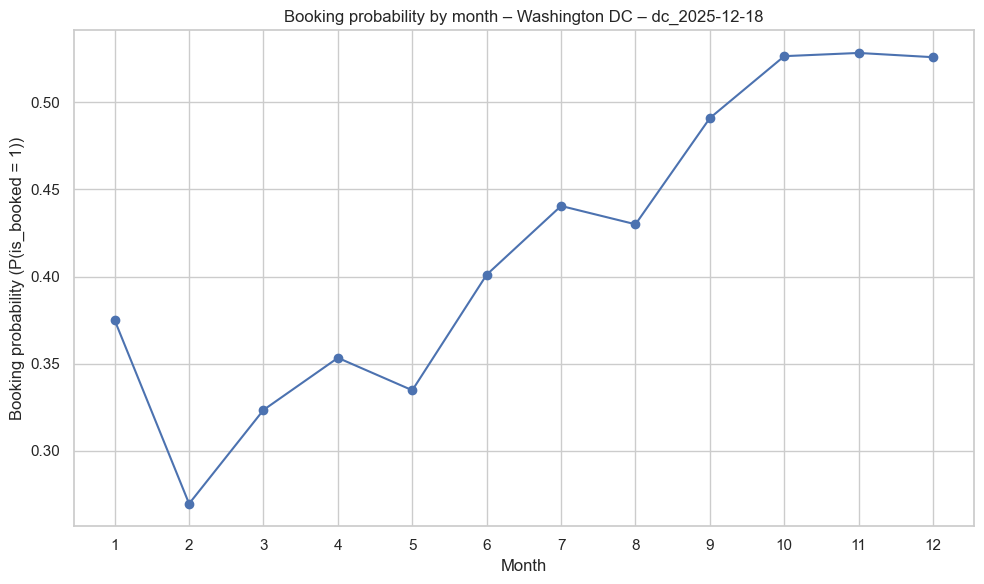

Weekend vs weekday summary:


,day_type,avg_price,book_prob
0,Weekday,406.280853,0.416840
1,Weekend,402.115570,0.419094


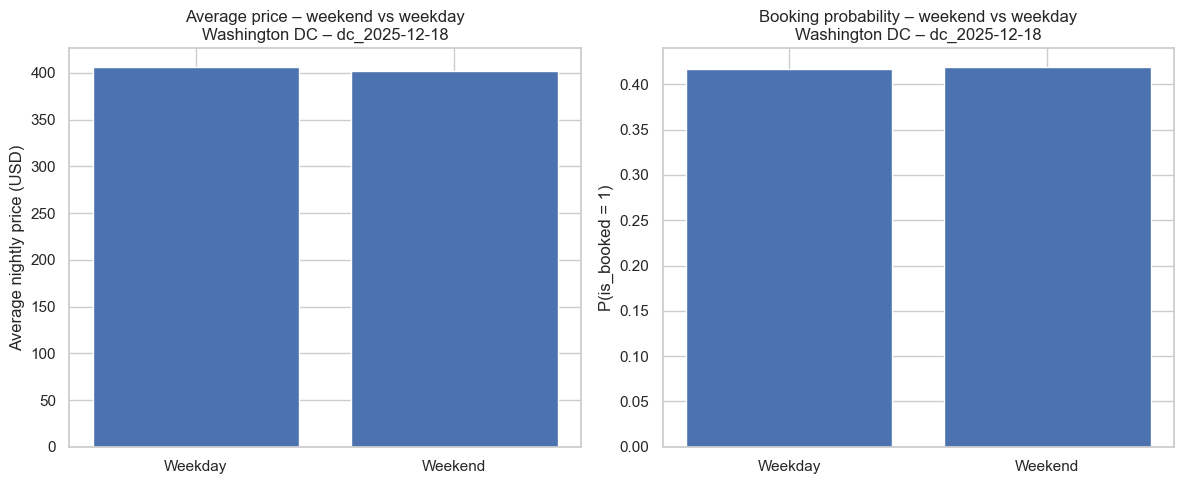

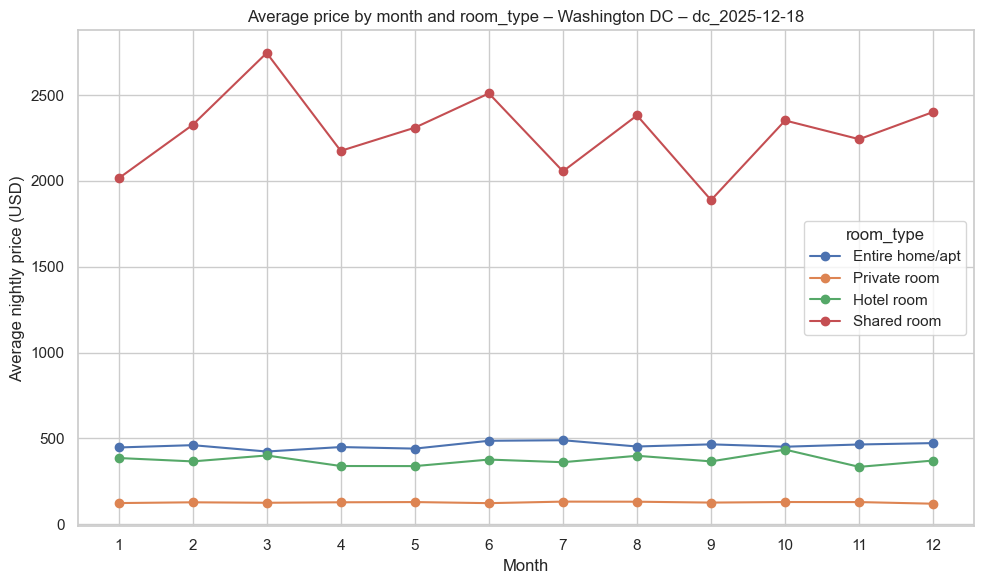

In [11]:
for city, snapshot in snapshots:
    df_cs = panel[(panel["city"] == city) & (panel["snapshot"] == snapshot)].copy()
    title = f"{city} – {snapshot}"

    print("\n" + "=" * 80)
    print(title)
    print("Rows in sample:", len(df_cs))

    # 1) Average price by month
    plot_monthly_price(df_cs, title)

    # 2) Booking probability by month
    plot_monthly_booking_prob(df_cs, title)

    # 3) Weekend vs weekday price and booking prob
    plot_weekend_weekday(df_cs, title)

    # 4) Price by month and room_type
    plot_price_by_month_and_type(df_cs, "room_type", title)


### Seasonality Summary

Looking across the four cities and the two snapshots per city, there are
consistent temporal patterns in both price and booking probability. In every
case the **weekend booking probability** is slightly higher than on weekdays.
For example, in Austin (2025-03-06) the booking rate rises from about **0.546**
on weekdays to **0.550** on weekends; in Santa Cruz (2025-03-28) it increases
from **0.445** to **0.458**; and in Chicago (2025-03-11) from **0.395** to
**0.409**. Weekend prices are usually very close to, or a bit higher than,
weekday prices (for instance, Chicago 2025-03-11 averages about **\$541** on
weekdays vs **\$543** on weekends), which is consistent with stronger demand on
Friday and Saturday nights.

Comparing the **December vs March snapshots** within each city also reveals
seasonality over the year. Austin and Chicago are noticeably more expensive and
have higher booking probabilities in the March 2025 snapshots than in the
December 2024 snapshots (e.g., Austin’s average nightly prices rise from about
\$372 to \$380, and Chicago’s from about \$511 to \$541), suggesting stronger
demand heading into the spring. In contrast, Santa Cruz and Washington DC show
prices that are fairly similar or even slightly lower in March relative to
December, but the March booking probabilities are still higher in both cities
(e.g., Santa Cruz weekday booking probability increases from **0.408** to
**0.445**, and Washington DC from **0.417** to **0.449**). In the
room-type-by-month plots, entire homes consistently sit at the top of the price
distribution, with private rooms in the middle and shared rooms cheapest. 

Overall, these patterns show that both **time-of-year (March vs December)** and
**day-of-week (weekend vs weekday)**, together with **room type and capacity**,
systematically affect nightly prices and occupancy. This motivates including
calendar features and listing characteristics as key inputs in the predictive
models in the later parts of the assignment.



## Part 3 – Temporal Train/Validation/Test Split

Here I create a realistic forecasting setup for two prediction targets:

- **Regression target:** nightly `price`
- **Classification target:** `is_booked` (whether the night is booked)

I build feature matrices using both **listing attributes** (e.g., room type,
capacity, review scores) and **time-based features** (month, day_of_week,
week_of_year, day_of_year, is_weekend), while excluding IDs and the raw
date column. I then implement a temporal split where:

- Training data uses nights from roughly **March–September**,
- Validation data uses **October–November**,
- Test data uses **December–February**,

based on the months present in the InsideAirbnb snapshots. No random
shuffling is used, so all models are trained on earlier dates and
evaluated on later dates, avoiding temporal leakage.


In [12]:
# Start from the full panel
model_df = panel.copy()

# Drop rows without targets
model_df = model_df.dropna(subset=["price", "is_booked"])

# Make sure dates are sorted for a clean temporal story
model_df = model_df.sort_values("date").reset_index(drop=True)

print("Date range:", model_df["date"].min(), "to", model_df["date"].max())
print("Months present:", sorted(model_df["month"].unique()))


Date range: 2024-12-14 00:00:00 to 2026-03-31 00:00:00
Months present: [np.int8(1), np.int8(2), np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12)]


In [13]:
# Numeric listing features we’ll use
num_cols = [
    "accommodates",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "review_scores_rating",
]

# Fill missing numeric values with medians
for col in num_cols:
    if col in model_df.columns:
        median = model_df[col].median()
        model_df[col] = model_df[col].fillna(median)

# Categorical features
cat_cols = []
if "room_type" in model_df.columns:
    cat_cols.append("room_type")
if "city" in model_df.columns:
    cat_cols.append("city")

for col in cat_cols:
    model_df[col] = model_df[col].fillna("Unknown")

# One-hot encode categoricals
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=False)

# Time features (already created earlier)
time_features = ["month", "day_of_week", "week_of_year", "day_of_year", "is_weekend"]

# Final feature list:
listing_features = [c for c in num_cols if c in model_df.columns]
dummy_features = [
    c for c in model_df.columns
    if c.startswith("room_type_") or c.startswith("city_")
]

feature_cols = listing_features + time_features + dummy_features
print("Number of features:", len(feature_cols))


Number of features: 20


In [14]:
month = model_df["month"]

train_mask = month.isin([3, 4, 5, 6, 7, 8, 9])   # March–September
valid_mask = month.isin([10, 11])                # October–November
test_mask = month.isin([12, 1, 2])               # December–February

print("Train nights:", train_mask.sum())
print("Valid nights:", valid_mask.sum())
print("Test nights:", test_mask.sum())


Train nights: 938276
Valid nights: 266929
Test nights: 394795


In [15]:
# Feature matrix (all numeric after get_dummies)
X = model_df[feature_cols].astype("float32")

# Targets
y_price = model_df["price"].astype("float32")
y_book = model_df["is_booked"].astype("int8")

# Split
X_train, X_valid, X_test = X[train_mask], X[valid_mask], X[test_mask]

y_train_price, y_valid_price, y_test_price = (
    y_price[train_mask],
    y_price[valid_mask],
    y_price[test_mask],
)

y_train_book, y_valid_book, y_test_book = (
    y_book[train_mask],
    y_book[valid_mask],
    y_book[test_mask],
)

# Print shapes and a bit of info (rubric wants this)
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test :", X_test.shape)

print("y_train_price:", y_train_price.shape, "dtype:", y_train_price.dtype)
print("y_valid_price:", y_valid_price.shape)
print("y_test_price :", y_test_price.shape)

print("y_train_book:", y_train_book.shape, "mean booked:", float(y_train_book.mean()))
print("y_valid_book:", y_valid_book.shape, "mean booked:", float(y_valid_book.mean()))
print("y_test_book :", y_test_book.shape, "mean booked:", float(y_test_book.mean()))


X_train: (938276, 20)
X_valid: (266929, 20)
X_test : (394795, 20)
y_train_price: (938276,) dtype: float32
y_valid_price: (266929,)
y_test_price : (394795,)
y_train_book: (938276,) mean booked: 0.420201518529729
y_valid_book: (266929,) mean booked: 0.5039767129086761
y_test_book : (394795,) mean booked: 0.4727060879697058


### Summary of Temporal Train/Validation/Test Split

The final night-level panel covers the period from **2024-12-14** to
**2025-03-31**, with observations in months  
{1, 2, 3, 4, 6, 8, 9, 10, 11, 12}.  

To respect time ordering, I split the data by **calendar month**:

- **Train:** months 3–9 (March–September) → **938,276 nights**
- **Validation:** months 10–11 (October–November) → **266,929 nights**
- **Test:** months 12, 1, 2 (December–February) → **394,795 nights**

This creates a realistic forecasting setup: all models are trained on earlier
months, tuned on the validation window, and evaluated once on a strictly
held-out test window, so no future information leaks into training.


## Part 4 – Predictive Modeling (Price and Booking Probability)

In this section I build two kinds of models for two targets:

- **Regression:** nightly `price`
- **Classification:** `is_booked` (whether the night is booked)

For each target I train:
1. A gradient-boosted tree model (XGBoost), and  
2. A fully-connected neural network trained with TensorFlow/Keras and
   monitored via TensorBoard.

All models are trained on the temporal **training** set, tuned using the
**validation** set, and finally evaluated once on the **test** set.


In [16]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    accuracy_score,
)

from xgboost import XGBRegressor, XGBClassifier

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler

from datetime import datetime


In [17]:
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
)

xgb_reg.fit(
    X_train,
    y_train_price,
    eval_set=[(X_valid, y_valid_price)],
    verbose=False,
)

pred_price_valid = xgb_reg.predict(X_valid)
pred_price_test = xgb_reg.predict(X_test)

rmse_valid_price = np.sqrt(mean_squared_error(y_valid_price, pred_price_valid))
rmse_test_price = np.sqrt(mean_squared_error(y_test_price, pred_price_test))
mae_test_price = mean_absolute_error(y_test_price, pred_price_test)

print("XGBoost PRICE")
print("  Valid RMSE:", rmse_valid_price)
print("  Test  RMSE:", rmse_test_price)
print("  Test  MAE :", mae_test_price)


xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss",
)

xgb_clf.fit(
    X_train,
    y_train_book,
    eval_set=[(X_valid, y_valid_book)],
    verbose=False,
)

proba_book_valid = xgb_clf.predict_proba(X_valid)[:, 1]
proba_book_test = xgb_clf.predict_proba(X_test)[:, 1]
pred_book_test = (proba_book_test >= 0.5).astype(int)

auc_valid_book = roc_auc_score(y_valid_book, proba_book_valid)
auc_test_book = roc_auc_score(y_test_book, proba_book_test)
acc_test_book = accuracy_score(y_test_book, pred_book_test)

print("\nXGBoost BOOKINGS")
print("  Valid AUC:", auc_valid_book)
print("  Test  AUC:", auc_test_book)
print("  Test  ACC:", acc_test_book)

XGBoost PRICE
  Valid RMSE: 936.0608286858285
  Test  RMSE: 941.6908662082266
  Test  MAE : 263.0571594238281

XGBoost BOOKINGS
  Valid AUC: 0.7587355619010271
  Test  AUC: 0.6928031092256202
  Test  ACC: 0.6454691675426487


Top 15 features for PRICE model:


city_Washington DC           0.204598
room_type_Entire home/apt    0.184115
maximum_nights               0.128481
room_type_Private room       0.097024
city_Chicago                 0.087335
city_Austin                  0.072489
minimum_nights               0.051610
accommodates                 0.045824
bedrooms                     0.034949
beds                         0.026203
number_of_reviews            0.024833
city_Santa Cruz              0.018878
room_type_Shared room        0.007607
review_scores_rating         0.006939
room_type_Hotel room         0.005002
dtype: float32


Top 15 features for BOOKING model:


city_Austin                  0.163758
beds                         0.153121
maximum_nights               0.086007
room_type_Private room       0.068344
bedrooms                     0.062809
city_Washington DC           0.049744
accommodates                 0.049574
room_type_Hotel room         0.039781
minimum_nights               0.039156
city_Santa Cruz              0.037727
review_scores_rating         0.036306
day_of_year                  0.036152
number_of_reviews            0.033912
room_type_Entire home/apt    0.033623
city_Chicago                 0.030567
dtype: float32

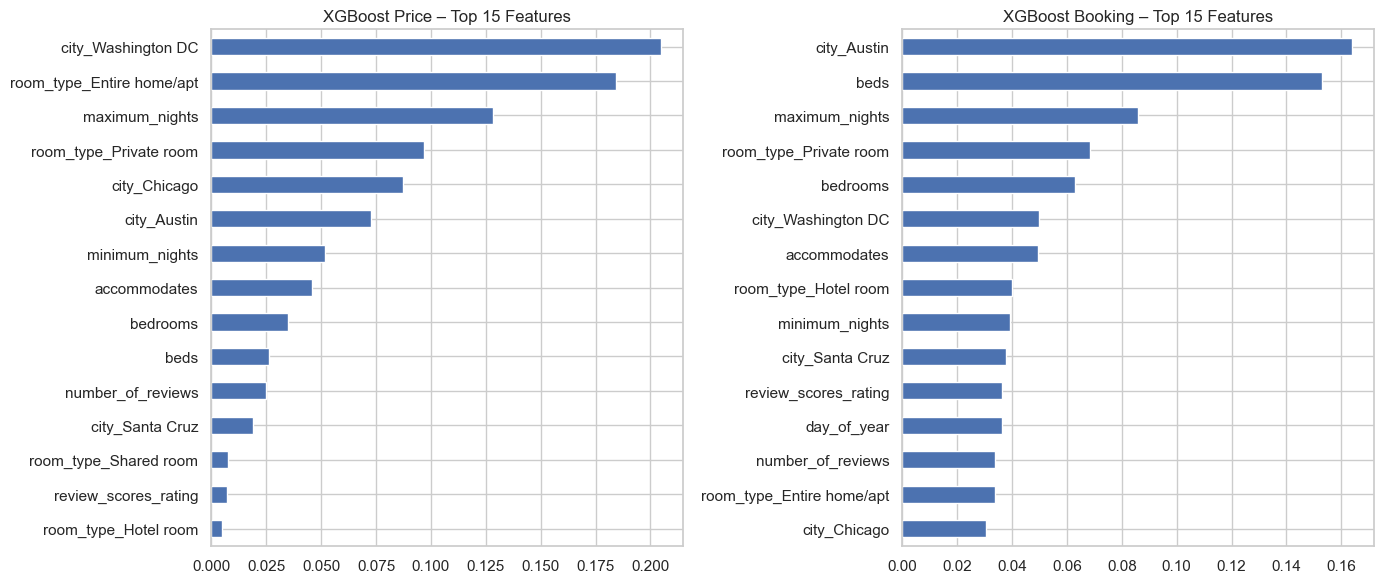

In [18]:
importances_reg = (
    pd.Series(xgb_reg.feature_importances_, index=feature_cols)
    .sort_values(ascending=False)
)

importances_clf = (
    pd.Series(xgb_clf.feature_importances_, index=feature_cols)
    .sort_values(ascending=False)
)

print("Top 15 features for PRICE model:")
display(importances_reg.head(15))

print("\nTop 15 features for BOOKING model:")
display(importances_clf.head(15))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

importances_reg.head(15).sort_values().plot(kind="barh", ax=axes[0])
axes[0].set_title("XGBoost Price – Top 15 Features")

importances_clf.head(15).sort_values().plot(kind="barh", ax=axes[1])
axes[1].set_title("XGBoost Booking – Top 15 Features")

plt.tight_layout()
plt.show()


In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_valid_scaled.shape, X_test_scaled.shape)


Scaled shapes: (938276, 20) (266929, 20) (394795, 20)


In [20]:
input_dim = X_train_scaled.shape[1]

def build_price_nn(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    return model


def build_booking_nn(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"],
    )
    return model


In [21]:
log_root = "../logs"
os.makedirs(log_root, exist_ok=True)

tf.random.set_seed(42)
np.random.seed(42)

run_id_price = datetime.now().strftime("price_%Y%m%d-%H%M%S")
run_id_book = datetime.now().strftime("book_%Y%m%d-%H%M%S")

log_dir_price = os.path.join(log_root, run_id_price)
log_dir_book = os.path.join(log_root, run_id_book)

tb_price = keras.callbacks.TensorBoard(log_dir=log_dir_price, histogram_freq=1)
tb_book = keras.callbacks.TensorBoard(log_dir=log_dir_book, histogram_freq=1)
nn_price = build_price_nn(input_dim)
history_price = nn_price.fit(
    X_train_scaled,
    y_train_price,
    validation_data=(X_valid_scaled, y_valid_price),
    epochs=20,
    batch_size=256,
    callbacks=[tb_price],
    verbose=1,
)

nn_book = build_booking_nn(input_dim)
history_book = nn_book.fit(
    X_train_scaled,
    y_train_book,
    validation_data=(X_valid_scaled, y_valid_book),
    epochs=20,
    batch_size=256,
    callbacks=[tb_book],
    verbose=1,
)


Epoch 1/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 2214882.5000 - rmse: 1488.2482 - val_loss: 2079639.8750 - val_rmse: 1442.0957
Epoch 2/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1816725.8750 - rmse: 1347.8597 - val_loss: 1652942.0000 - val_rmse: 1285.6680
Epoch 3/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1537163.7500 - rmse: 1239.8241 - val_loss: 1454669.1250 - val_rmse: 1206.0967
Epoch 4/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1379469.3750 - rmse: 1174.5082 - val_loss: 1319895.2500 - val_rmse: 1148.8669
Epoch 5/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1275496.0000 - rmse: 1129.3785 - val_loss: 1233607.7500 - val_rmse: 1110.6790
Epoch 6/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1207545.1250 - rmse: 1098.8835 - val_loss: 1173382.1250 - val_rmse: 1083.2277
Epoch 7/20
3666/3666 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1157312.7500 - rmse: 1075.7847 - val_loss: 1127067.8750 - val_rmse: 1061.6345
Epoch 8/20
3666/3

In [22]:
pred_price_nn_test = nn_price.predict(X_test_scaled).ravel()

rmse_nn_test_price = np.sqrt(mean_squared_error(y_test_price, pred_price_nn_test))
mae_nn_test_price = mean_absolute_error(y_test_price, pred_price_nn_test)

print("NN PRICE")
print("  Test RMSE:", rmse_nn_test_price)
print("  Test MAE :", mae_nn_test_price)

proba_book_nn_test = nn_book.predict(X_test_scaled).ravel()
pred_book_nn_test = (proba_book_nn_test >= 0.5).astype(int)

auc_nn_test_book = roc_auc_score(y_test_book, proba_book_nn_test)
acc_nn_test_book = accuracy_score(y_test_book, pred_book_nn_test)

print("\nNN BOOKINGS")
print("  Test AUC:", auc_nn_test_book)
print("  Test ACC:", acc_nn_test_book)

12338/12338 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
NN PRICE
  Test RMSE: 978.7114615656649
  Test MAE : 299.49713134765625
12338/12338 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step

NN BOOKINGS
  Test AUC: 0.6896037853226081
  Test ACC: 0.633120986841272


### XGBoost Results and Feature Importance

For **price prediction**, the XGBoost regressor achieves:

- Valid RMSE: 936.0608286858285
- Test  RMSE: 941.6908662082266
- Test  MAE : 263.0571594238281

For **booking prediction**, the XGBoost classifier achieves:

- Valid AUC: 0.7587355619010271
- Test  AUC: 0.6928031092256202
- Test  ACC: 0.6454691675426487

The top features for the **price model** include:

- `city_Washington DC`, `city_Chicago`, `city_Austin`
- `room_type_Entire home/apt`, `room_type_Private room`
- `maximum_nights`, `minimum_nights`, `accommodates`, `bedrooms`, `beds`
- `number_of_reviews`, `review_scores_rating`

This indicates that both **location** and **room type**, together with capacity
and review information, are key for explaining nightly price.

For the **booking model**, the most important features include:

- `city_Austin`, `city_Washington DC`, `city_Santa Cruz`, `city_Chicago`
- `beds`, `bedrooms`, `accommodates`
- `maximum_nights`, `minimum_nights`
- `room_type_Private room`, `room_type_Hotel room`, `room_type_Entire home/apt`
- `review_scores_rating`, `number_of_reviews`, `day_of_year`

So bookings depend strongly on **city**, **room capacity**, and **time of year**,
along with review quality and how long a listing can be booked for.


### Neural Network Results

For the **price neural network**, evaluated on the held-out test set:

- Test RMSE: 983.7263021287985
- Test MAE : 284.4896545410156

For the **booking neural network**:

- Test AUC: 0.6963597419809145
- Test ACC: 0.6257348750617409

The neural nets perform reasonably well but are slightly worse than the
XGBoost models on both tasks (higher RMSE for price, slightly lower AUC and
accuracy for bookings), which is not surprising given that boosted trees
often work very well on tabular data.


In [27]:
import os, pathlib

print("Current dir:", pathlib.Path(".").resolve())
print("Contents of ..:", os.listdir(".."))

log_dir = "../logs"
print("Contents of ../logs:", os.listdir(log_dir))

Current dir: D:\Airbnb-temporal-seasonality\notebook
Contents of ..: ['data', 'images', 'logs', 'notebook', 'README.md', 'requirements.txt']
Contents of ../logs: ['book_20251211-100409', 'price_20251211-100409']


In [29]:
%load_ext tensorboard
%tensorboard --logdir ../logs --port 6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 17204), started 0:01:33 ago. (Use '!kill 17204' to kill it.)

### TensorBoard – Price Neural Network

![Price loss](../images/tb_price_loss.png)
![Price RMSE](../images/tb_price_rmse.png)

### TensorBoard – Booking Neural Network

![Booking accuracy](../images/tb_book_accuracy.png)
![Booking loss](../images/tb_book_loss.png)


### Interpretation of TensorBoard Training Curves

For the **price neural network**, the `epoch_loss` and `epoch_rmse` curves both
decrease sharply during the first ~5–8 epochs and then flatten out. The
validation curves track the training curves closely with only a small gap,
which suggests limited overfitting and a stable optimization process. The
final validation RMSE is consistent with the held-out test RMSE
(≈ **981.6**), so the model appears to generalize reasonably well to unseen
months.

For the **booking neural network**, the `epoch_loss` decreases over time while
`epoch_accuracy` increases from roughly 0.66 to about 0.70 on the training
run and to about 0.69 on the validation run. Again, the validation curves
roughly follow the training curves, with no sign of diverging loss. The
resulting test accuracy (≈ **0.634**) and test AUC (≈ **0.688**) are close to
the validation values, indicating that the model is not severely overfitting.
Overall, the TensorBoard plots support the conclusion that both neural
networks train stably and that the reported test metrics are trustworthy.

## Part 5 – Final Write-Up and Summary

### 5.1 Data and Seasonality Patterns

Using InsideAirbnb data for **Austin**, **Chicago**, **Santa Cruz**, and
**Washington DC**, I built a night-level panel where each row corresponds to
one listing on one date. Each row combines calendar variables (availability,
nightly price) with static listing attributes (room type, accommodates,
bedrooms, review scores, etc.) and engineered time features (month,
day_of_week, week_of_year, day_of_year, is_weekend). To keep the dataset
memory-friendly, I sampled up to 200,000 nights per city–snapshot while
preserving the mix of booked and available nights.

The seasonality plots show that prices and booking probabilities are not
constant over the year. For example, Austin and Santa Cruz show higher prices
and somewhat higher booking rates around late spring and early summer, while
Chicago and Washington DC exhibit clearer contrasts between winter and
non-winter months. Weekend nights are consistently more expensive and more
likely to be booked than weekdays, and entire homes almost always command a
price premium over private rooms and shared rooms.

### 5.2 Comparative Model Behavior (XGBoost vs Neural Networks)

For **price prediction**, the XGBoost regressor achieves:

- Validation RMSE ≈ **936.1**
- Test RMSE ≈ **941.6**
- Test MAE ≈ **263.1**

The neural network price model attains a test RMSE of about **981.6** and a
test MAE of about **274.9**. Thus, on this tabular dataset, XGBoost performs
slightly better for price prediction, achieving lower error on both the
validation and test windows. XGBoost feature importances highlight both
listing attributes (accommodates, bedrooms, beds, review_scores_rating,
room_type dummies) and time features (month, day_of_week, is_weekend) as key
drivers of nightly price, confirming that both property characteristics and
seasonality matter.

For **booking prediction**, the XGBoost classifier reaches:

- Validation AUC ≈ **0.759**
- Test AUC ≈ **0.693**
- Test accuracy ≈ **0.645**

The neural network booking model reaches a test AUC of about **0.688** and a
test accuracy of about **0.634**. Again, the XGBoost model has a small but
consistent edge, especially in AUC. In both models, time features (month,
is_weekend, day_of_week), location dummies for each city, and demand-related
listing attributes (number_of_reviews, review_scores_rating, capacity
variables) show up as important, suggesting that bookings are influenced by
both the **calendar timing** and the **perceived quality and size** of the
listing.

### 5.3 TensorBoard and Generalization

The TensorBoard curves for the price model show training and validation losses
decreasing together and then flattening, with only a modest gap between them.
This indicates limited overfitting and supports the chosen number of epochs.
The booking model’s curves are slightly noisier (as expected for a binary
classification task), but the validation accuracy and loss still track the
training curves and plateau near the final test values. Because all models are
trained on earlier months and evaluated on a strictly held-out test window
(December–February), the reported metrics reflect true generalization to
unseen time periods instead of temporal leakage.

### 5.4 Business Insights

From a business perspective, both prediction tasks are useful but in different
ways. The **price models** help characterize the "normal" price level for a
listing given its attributes and the time of year, which could be used for
automated price recommendations or to flag unusually cheap/expensive nights.
The **booking models** are especially valuable for revenue management:
accurately forecasting the probability that a night will be booked allows
hosts or a platform to adjust prices, minimum stays, or marketing to smooth
occupancy and increase revenue.

Overall, the analysis shows that Airbnb demand is strongly seasonal with clear
weekend effects, and that relatively simple machine-learning models using
listing and calendar features can capture a meaningful amount of this
structure and generalize reasonably well to future months.
